In [1]:
import tensorflow as tf

from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D, BatchNormalization

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [2]:
import io
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.vgg19 import preprocess_input, VGG19
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
import datetime
import matplotlib.pyplot as plt

In [3]:
def _parse_function(tfrecord_proto):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
    }
    parsed_features = tf.io.parse_single_example(tfrecord_proto, feature_description)
    
    image = tf.io.decode_png(parsed_features['image'], channels=3)
    image = tf.image.resize(image, [224, 224], method=tf.image.ResizeMethod.BILINEAR)

    image = tf.cast(image, tf.float32) / 255.0
    
    return image

In [4]:
def load_dataset_from_tfrecord(tfrecord_path):
    dataset = tf.data.TFRecordDataset(tfrecord_path)
    return dataset.map(_parse_function)
    
tfrecord_path = '/Users/anantha_padmanaban/Documents/projects/GANs/test_model/tfrecord/sample_data.tfrecord'
dataset = load_dataset_from_tfrecord(tfrecord_path)
for images in dataset.take(5):  
    print('Image shape:', images.numpy().shape)

Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)
Image shape: (224, 224, 3)


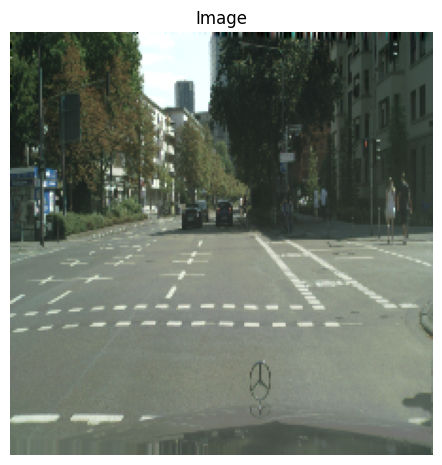

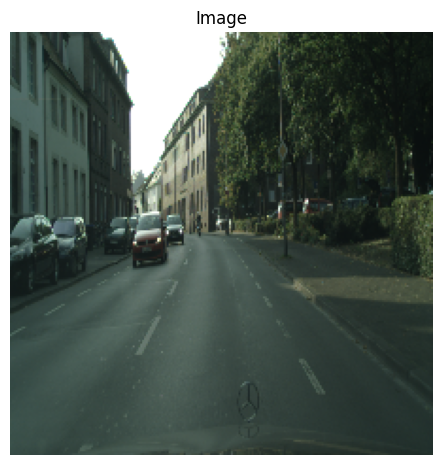

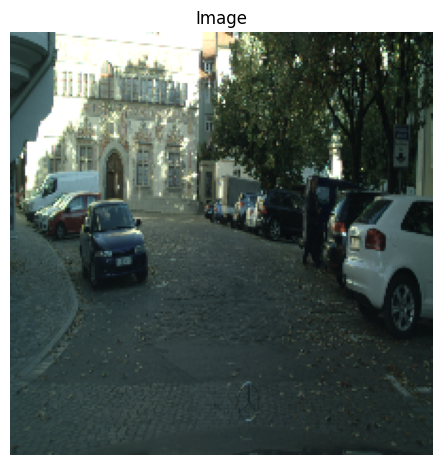

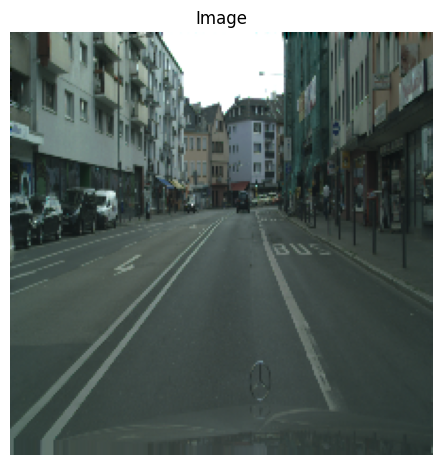

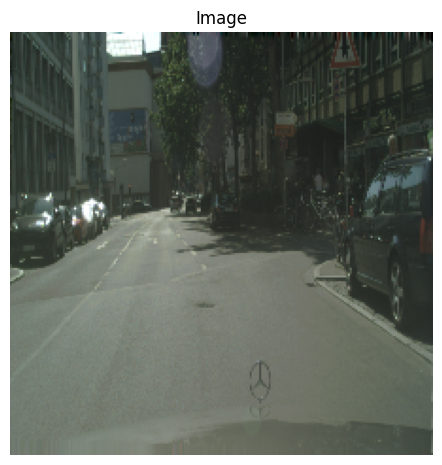

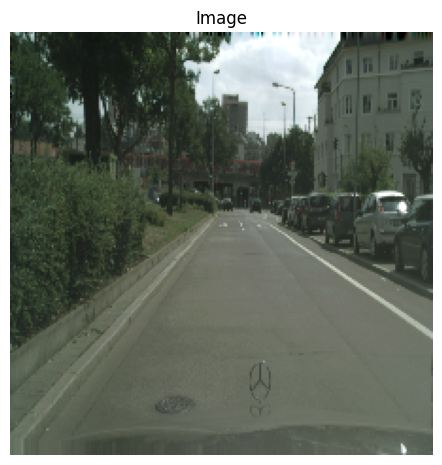

In [5]:
def visualize_image_and_mask(image):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.title('Image')
    plt.imshow(image)
    plt.axis('off')
    plt.show()
for images in dataset.take(6): 
    visualize_image_and_mask(images.numpy())

In [6]:
SHUFFLE_BUFFER_SIZE = 300  
BATCH_SIZE = 4
DATASET_SIZE = 500  

dataset = dataset.shuffle(SHUFFLE_BUFFER_SIZE).repeat()

TRAIN_SIZE = DATASET_SIZE

train_dataset = dataset.take(TRAIN_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

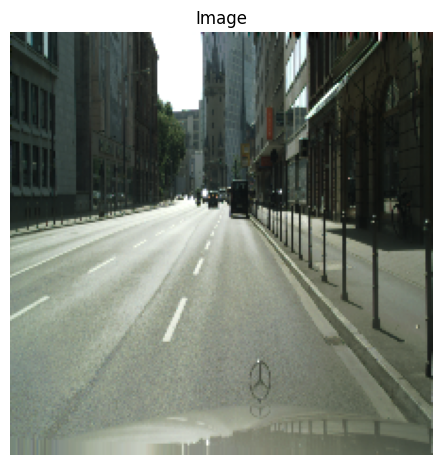

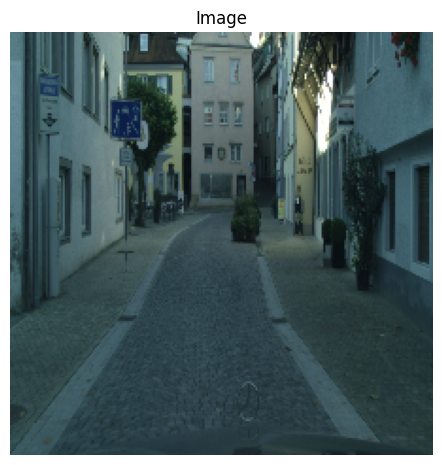

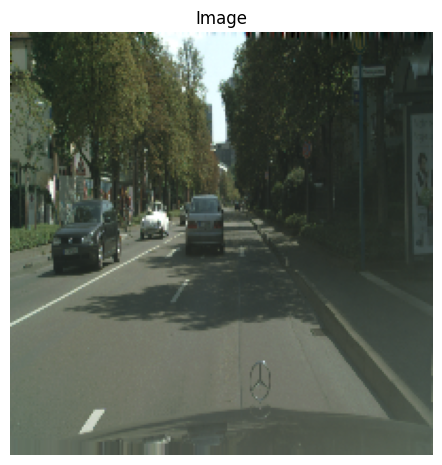

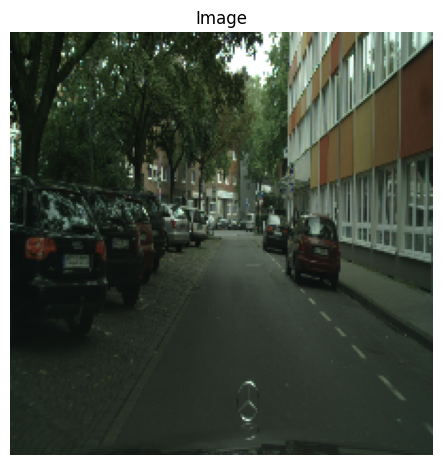

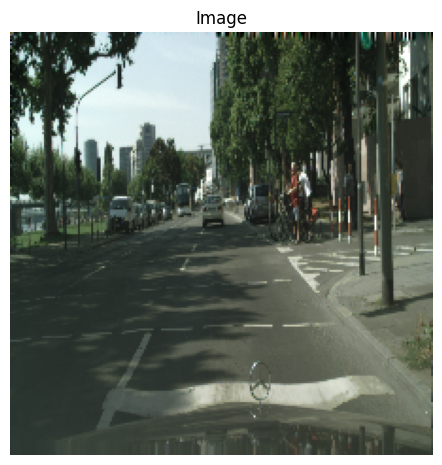

In [7]:
def visualize_image_and_mask(image):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.title('Image')
    plt.imshow(image)
    plt.axis('off')
for images in dataset.take(5):
    visualize_image_and_mask(images.numpy())

In [8]:
print(TRAIN_SIZE)
print(len(train_dataset))

for images in train_dataset.take(1):
    print('Images batch shape:', images.shape)

500
125
Images batch shape: (4, 224, 224, 3)


In [9]:
vgg = VGG19(include_top=False, input_shape=(224, 224, 3))
vgg.trainable = False

In [10]:
def build_generator():
    model = Sequential()
    # Beginnings of a generated image
    model.add(Dense(7*7*1024, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((7, 7,1024)))
    
    # 1 
    model.add(UpSampling2D())
    model.add(Conv2D(1024, 4, padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(0.2))
    
    # 2
    model.add(Conv2D(1024, 4, padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(0.2))
    # model.add(Conv2D(1024, 4, padding='same'))
    # model.add(LeakyReLU(0.2))
    
    # 3
    model.add(UpSampling2D())
    model.add(Conv2D(512, 4, padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(0.2))
    # model.add(Conv2D(512, 4, padding='same'))
    # model.add(LeakyReLU(0.2))

    # 4
    model.add(Conv2D(512, 4, padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(0.2))
    
    
    # 5
    model.add(UpSampling2D())
    model.add(Conv2D(256, 4, padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    # model.add(Conv2D(256, 4, padding='same'))
    # model.add(LeakyReLU(0.2))

    #6
    model.add(Conv2D(256, 4, padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(0.2))
    # model.add(Conv2D(256, 4, padding='same'))
    # model.add(LeakyReLU(0.2))

    #7
    model.add(UpSampling2D())
    model.add(Conv2D(128, 4, padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(0.2))

    #8
    model.add(Conv2D(128, 4, padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(0.2))
    # model.add(Conv2D(128, 4, padding='same'))
    # model.add(LeakyReLU(0.2))

    #9
    model.add(UpSampling2D())
    model.add(Conv2D(64, 4, padding='same'))
    model.add(BatchNormalization(momentum=0.8))
    # model.add(Conv2D(64, 4, padding='same'))
    # model.add(LeakyReLU(0.2))
    
    # Conv layer to get to one channel
    model.add(Conv2D(3, kernel_size=3, padding='same', activation='tanh'))
    
    return model

In [11]:
generator = build_generator()

In [12]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50176)             6472704   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 50176)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 1024)        0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 1024)      0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 1024)      16778240  
                                                                 
 batch_normalization (Batch  (None, 14, 14, 1024)      4096      
 Normalization)                                         

In [13]:
img = generator.predict(np.random.randn(4,128,1))

1/1 [==============================] - 1s 1s/step


1/1 [==============================] - 1s 798ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


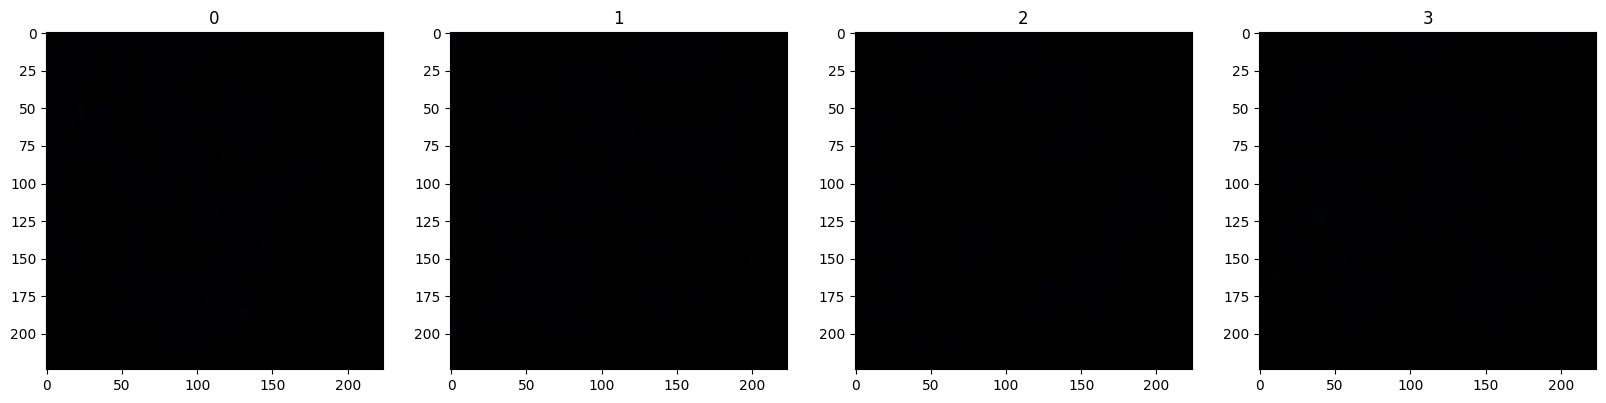

In [14]:
# Generate new fashion
img = generator.predict(np.random.randn(4,128,1))
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx, img in enumerate(img): 
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(img))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(idx)

In [15]:
def build_discriminator():
    model = tf.keras.Sequential([
        vgg,
        layers.Flatten(),
        layers.Dense(1024),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

In [16]:
discriminator = build_discriminator()

In [17]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 1024)              25691136  
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 45716545 (174.39 MB)
Trainable params: 2

In [18]:
class FashionGAN(Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.generator = generator 
        self.discriminator = discriminator 
        
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        super().compile(*args, **kwargs)
        
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):
        # Get the data 
        real_images = batch
        fake_images = self.generator(tf.random.normal((4, 128, 1)), training=False)
        with tf.GradientTape() as d_tape: 
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss - BINARYCROSS 
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator 
        with tf.GradientTape() as g_tape: 
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
            predicted_labels = self.discriminator(gen_images, training=False)
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [19]:
g_opt = Adam(learning_rate=0.0001) 
d_opt = Adam(learning_rate=0.00001) 
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [20]:
fashgan = FashionGAN(generator, discriminator)

In [21]:
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

In [22]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

In [ ]:
hist = fashgan.fit(train_dataset, epochs=2000, callbacks=[ModelMonitor()])

Epoch 1/2000
  1/125 [..............................] - ETA: 6:04:59 - d_loss: 0.8331 - g_loss: 1.2863